In [1]:
# import numpy as np
from toy_datasets import *
from BootstrappedNonparametrics.nonparametrics import *
import os 
import math
import pdb
import random
import time
import multiprocessing as mp
from scipy.sparse import csr_matrix 
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn import mixture 
from joblib import  Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import scipy.io as sio
from scipy.spatial.distance import squareform
import math
# np.random.seed(13455)

In [2]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

class MyDataset:
    def __init__(self, x_data, y_data, ):
        self.xdata = x_data
        self.ydata = y_data        
    
    def gen_splits(self, train_frac = .7, calib_frac = .1, test_frac = .2):
        #TODO: this should be part of the init function somehow, since this kind of thing should be handled when the datset is created
        
        assert train_frac + calib_frac + test_frac == 1., 'Sum of train/test/calib split must equal 1'
        
        self.train_frac, self.test_frac, self.calib_frac = train_frac, test_frac, calib_frac

        inds = np.arange(len(self.xdata))
        xtrcalib, xtest, ytrcalib, ytest, inds_trcalib, inds_test = train_test_split(self.xdata, self.ydata, inds, test_size=test_frac)
        xtrain, xcalib, ytrain, ycalib, inds_tr, inds_calib = train_test_split(xtrcalib, ytrcalib, inds_trcalib, test_size=calib_frac/(1-test_frac))
        
        self.xtrain, self.ytrain = xtrain, ytrain
        self.xtest, self.ytest = xtest, ytest
        self.xcalib, self.ycalib = xcalib, ycalib
        
        self.inds_trcalib = inds_trcalib
        self.inds_tr = inds_tr
        self.inds_test = inds_test
        self.inds_calib = inds_calib
        print('Split dataset. n_train %d, n_calib %d, n_test %d.' % (len(xtrain), len(xcalib), len(xtest)))


''' Generate Posterior Distribution '''

#TODO: put these into some kind of posterior estimator class, make all of these static methods
def estimate_posterior(data, labels):
    '''
    data - [n_points, n_dimensions]
    labels - [n_points, 2]
    '''
    
    n_points = data.shape[0]

    return None

def simple_knn_posterior_estimate(data, labels, k, kernel=None):
    '''
    data - [n_points, n_dimensions]
    labels - [n_points, 2]
    '''
    
    def _compute_ber(neighbdata, neighborlabels, centerlabel):
        errors = np.sum(np.abs(neighborlabels - centerlabel))
#         print(errors)
        N = np.sum(neighborlabels==0)
        M = np.sum(neighborlabels==1)
        if N==0 or M==0:
            kerneldp = 1.
            kernelBayesLB = 0.
        else:
            kerneldp = 1 - ((M + N) / (2 * M * N)) * errors
            if kerneldp<=0:
                kerneldp=0.
                kernelBayesLB = 0
            else:
                kernelBayesLB = .5 - .5 * np.sqrt(kerneldp)
        return kernelBayesLB
    
    def _compute_1nn_threshold():
        nbrs = NearestNeighbors(n_neighbors = k + 1).fit(data)
        distances, inds = nbrs.kneighbors(data)
        
        
    n_points = data.shape[0]
    nbrs = NearestNeighbors(n_neighbors = k + 1).fit(data)
    distances, inds = nbrs.kneighbors(data)
    posterior_value = np.zeros([n_points,1])
    ber_estimates = np.zeros([n_points, 1])
    posterior_var = np.zeros([n_points,1])
    posterior_thresh = np.zeros([n_points, 1])
    ber_var = np.zeros([n_points, 1])
    
    for ii in range(n_points):
        neighblabels = labels[inds[ii, ]]
        neighbdata = data[inds[ii,:]]
        posterior_value[ii] = sum(neighblabels[1:])/k
        ber_estimates[ii] = _compute_ber(neighbdata[1:], neighblabels[1:], neighblabels[0])
    
    for ii in range(n_points):
        neighb_ber = ber_estimates[inds[ii, :]]
        neighb_posterior= posterior_value[inds[ii, :]]
        ber_var[ii] = np.var(neighb_ber[1:])
        posterior_var[ii] = np.var(neighb_posterior[1:])
        posterior_thresh[ii] = sum(neighb_posterior[1:]-neighb_posterior[0]>(1/k))
    return posterior_value, ber_estimates, posterior_var, ber_var, posterior_thresh


In [3]:
import ml_insights as mli
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# random_state = 123455

class CalibratedClassifier:
    def __init__():
        pass
    

#see how to make these into object oriented
def train_classifier(xtrain, ytrain, classifier):
    
    if 'svm' in classifier:
        clf = SVC(gamma = 'auto', probability=True, max_iter = 1000, class_weight='balanced')
        
    elif 'forest' in classifier:
        clf = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', n_jobs=4)
    
    elif 'logistic' in classifier:
        clf = LogisticRegression(solver='lbfgs', class_weight='balanced_sample')
        
    clf.fit(xtrain, ytrain)
    return clf


def accuracy(yhat, y):
    return np.mean(yhat==y)

def mse(yhat, y):
    return np.mean((yhat - y) ** 2)

def evaluate_classifier(clf, xdata, ydata, score_fn):
    return score_fn(clf.predict(xdata), ydata)

def get_uncalibrated_probas(clf, xdata, classifier):
    if classifier.lower()=='svm':
        pass
    elif classifier.lower()=='forest':
        pass
    else:
        print('Classifier must be either SVM or Forest')
        return Exception
    

In [4]:
trainfrac = .75
calibfrac = .1
testfrac = 1 - trainfrac - calibfrac

Split dataset. n_train 3749, n_calib 501, n_test 750.


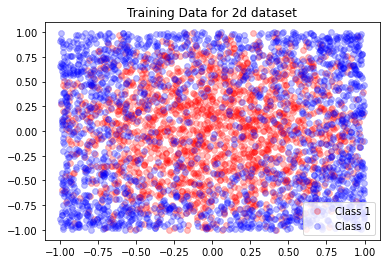

In [5]:
# ''' Generate and plot dataset'''

# x0, x1, ylabels = gen_simple_binary_data(N = 5000, mu_y = 1.5 * np.ones([1, 2]), ndims = 2)
# xgaussian = np.vstack([x0, x1])
# dataset = MyDataset(x_data = xgaussian, y_data = ylabels)

x0square, x1circle, ysqcirc = inscribed_circle_dataset(N=5000, radius=.8, sidelen=2, sigma=.5)
xdata = np.vstack([x0square, x1circle])
dataset = MyDataset(x_data = xdata, y_data = ysqcirc)


# xlin, ylin = gen_linear_dataset(N=10000, sigma=.5)
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score


dataset.gen_splits(train_frac=trainfrac, calib_frac=calibfrac, test_frac=testfrac)
plot_2d_dataset(dataset.xtrain, dataset.ytrain, title = 'Training Data for 2d dataset')
# plt.figure()
# xdata = dataset.xtrain
# labels = dataset.ytrain
# plt.scatter(xdata[labels==1, 0], xdata[labels==1, 1], color='r', alpha=.25, marker='8', s=1, label='Class 1')
# plt.scatter(xdata[labels==0, 0], xdata[labels==0, 1], color='b', alpha=.25, marker='8', s=1, label='Class 0')
# plt.title(title)
plt.legend()
plt.grid()
    


/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.48
Trained SVM with test accuracy: 0.48
Calibration set acccuracy: 0.44 
It is clear that the SVM is not calibrated


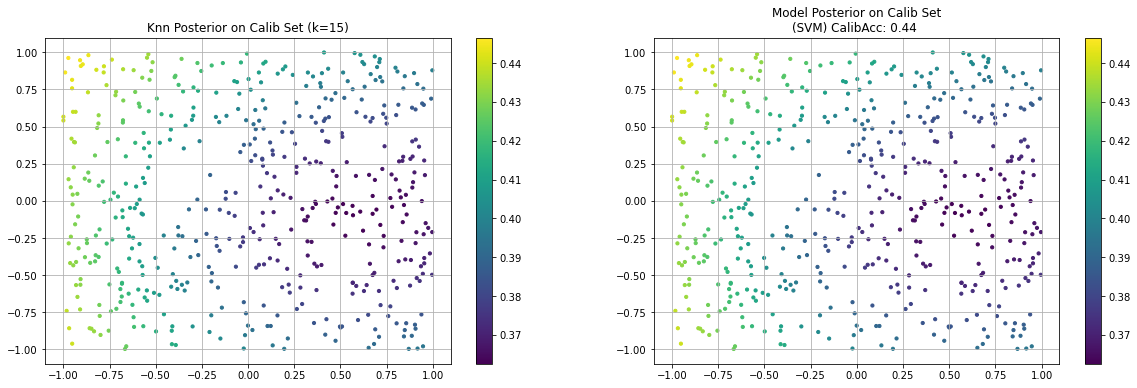

/home/prad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/prad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'Num Points in Bin')

<Figure size 432x288 with 0 Axes>

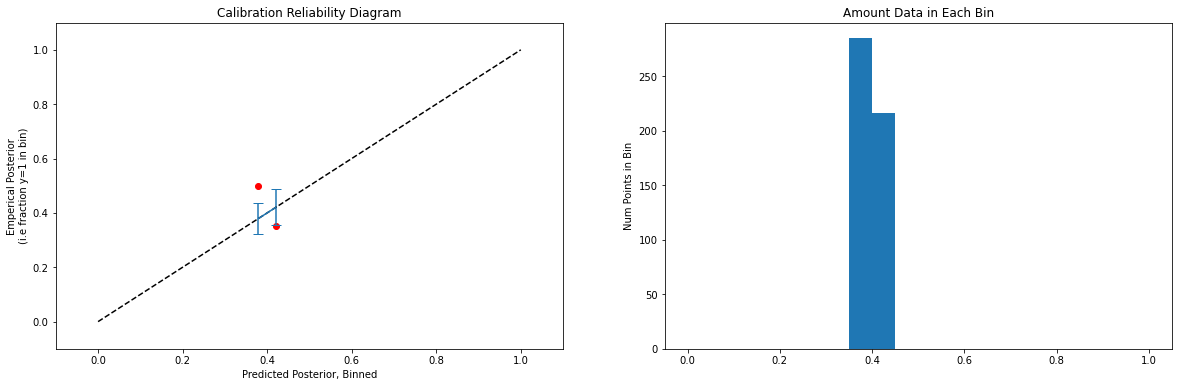

In [6]:
''' Train model, and evaluate if it is calibrated '''

knum = 15
kcalib = int(knum * dataset.calib_frac/dataset.train_frac)
ktest = int(knum * dataset.calib_frac/dataset.train_frac)
#train model (SVM)
svmclf = train_classifier(dataset.xtrain, dataset.ytrain, classifier='svm')

#evaluate accuracy
trainacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtrain, ydata=dataset.ytrain, score_fn=accuracy)
calibacc = evaluate_classifier(clf=svmclf, xdata=dataset.xcalib, ydata=dataset.ycalib, score_fn=accuracy)
testacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtest, ydata=dataset.ytest, score_fn=accuracy)
print(testacc)
print('Trained SVM with test accuracy: %.2f' % testacc)
print('Calibration set acccuracy: %.2f ' % calibacc)
print('It is clear that the SVM is not calibrated')

#evaluate model posterior
trscore = svmclf.predict_proba(dataset.xtrain)
calibscore = svmclf.predict_proba(dataset.xcalib)
calibset_model_posterior = calibscore[:, 1].reshape(-1, 1)
testset_model_posterior = svmclf.predict_proba(dataset.xtest)[:, 1].reshape(-1, 1)

# Knn posterior 
trposterior, trber, trposterior_variance, trber_variance, trposterior_thresh = simple_knn_posterior_estimate(data=dataset.xtrain, labels=dataset.ytrain, k=knum)
calibposterior, calibber, calposterior_variance, calber_variance, calposterior_thresh = simple_knn_posterior_estimate(data=dataset.xcalib, labels=dataset.ycalib, k=knum)
testsetposterior, testsetber, teposterior_variance, teber_variance, teposterior_thresh = simple_knn_posterior_estimate(data=dataset.xtest, labels=dataset.ytest, k=ktest)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Knn Posterior on Calib Set (k=%d)' % knum)
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Model Posterior on Calib Set\n(SVM) CalibAcc: %.2f ' % (calibacc))
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.show()

plt.figure()
# rd = mli.plot_reliability_diagram(dataset.ycalib, calibscore[:,1])
plt.figure(figsize=(20,6))
mli.plot_reliability_diagram(dataset.ycalib, calibset_model_posterior.ravel(), show_histogram=True);
plt.subplot(1,2,1)

plt.title('Calibration Reliability Diagram')
plt.ylabel('Emperical Posterior\n(i.e fraction y=1 in bin)')
plt.xlabel('Predicted Posterior, Binned')
plt.subplot(1,2,2)

plt.title('Amount Data in Each Bin')
plt.ylabel('Num Points in Bin')

# 

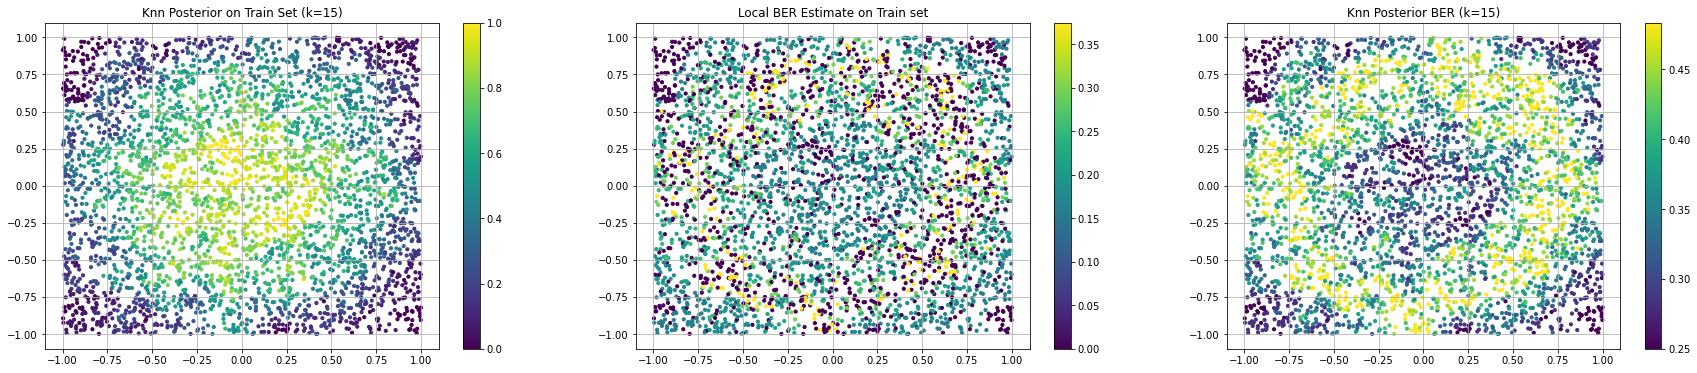

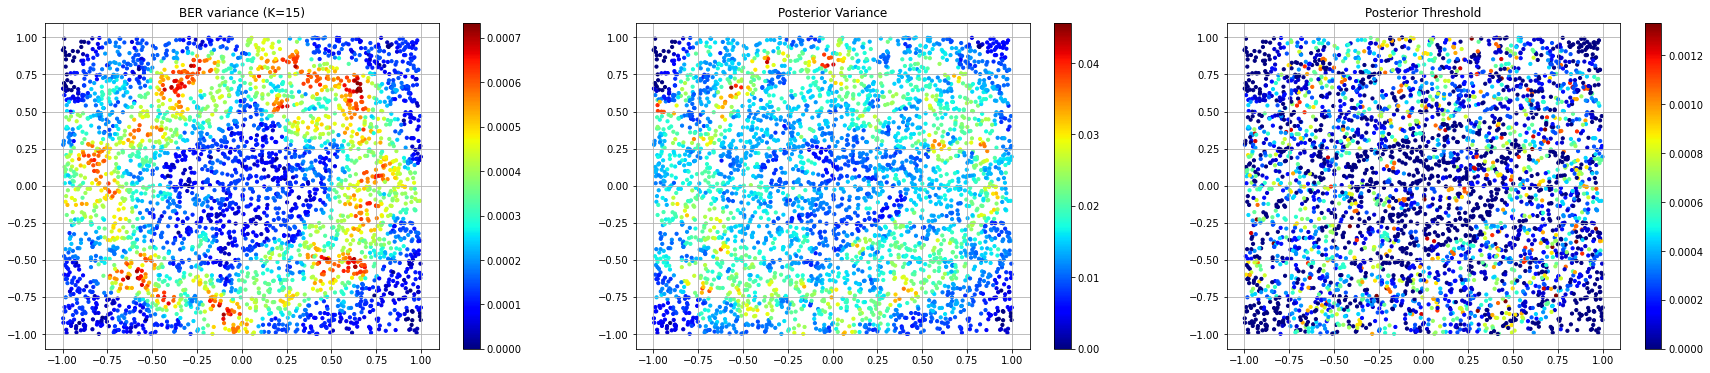

In [7]:
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Knn Posterior on Train Set (k=%d)' % knum)
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=trposterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.subplot(1,3,2)
plt.title('Local BER Estimate on Train set' )
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=trber, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.subplot(1,3,3)
plt.title('Knn Posterior BER (k=%d)' % knum)
trposteriorber = .5*(1-np.abs(trposterior-.5))
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=trposteriorber, s=10, cmap=plt.cm.viridis)
plt.colorbar()

plt.grid()
plt.show()

trber_wts = trber_variance/sum(trber_variance)
trpostvar_wts = trposterior_variance/sum(trposterior_variance)
trpostthresh_wts = trposterior_thresh/sum(trposterior_thresh)


plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('BER variance (K=%d)' % knum)
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=trber_wts, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Posterior Variance' )
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=np.sqrt(trpostvar_wts), s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Posterior Threshold' )
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=trpostthresh_wts, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.show()

In [8]:
''' Classifier calibration functions'''

from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

def get_platt_calibrator(yhat_uncalibrated, ycalib):
    lrcalib = LogisticRegression(C=999999999999, solver='lbfgs')
    lrcalib.fit(yhat_uncalibrated, ycalib)
    return lrcalib

def platt_calibrate(trained_calibrator, yhat):
    return trained_calibrator.predict_proba(yhat)[:, 1]

def get_isotonic_calibrator(yhat_uncalibrated, ycalib):
    iso_calib = IsotonicRegression(out_of_bounds = 'clip')
    iso_calib.fit(yhat_uncalibrated, ycalib)
    return iso_calib

def isotonic_calibrate(trained_calibrator, yhat):
    return trained_calibrator.predict(yhat)

Text(0.5, 1.0, 'Test Data, Platt Calibrated Outputs')

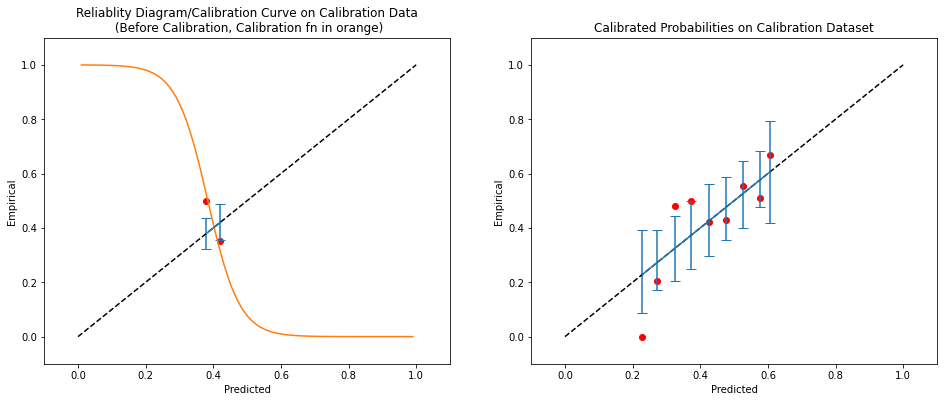

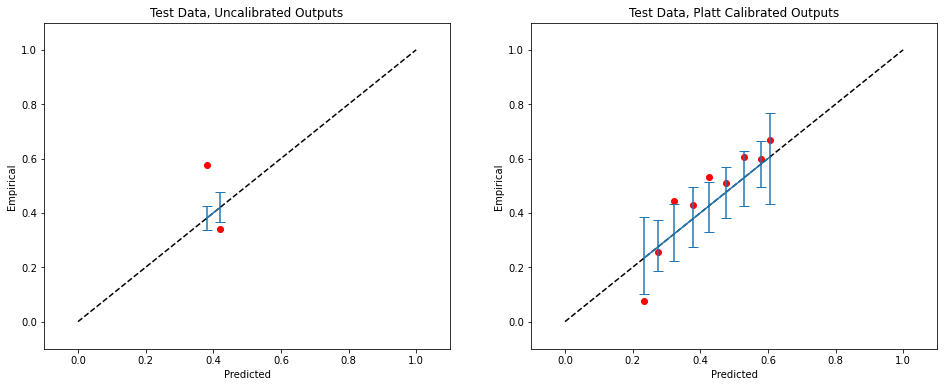

In [9]:
''' platt calibration function'''
pvec = np.linspace(.01, .99, 99)
lrcalib = get_platt_calibrator(calibset_model_posterior, dataset.ycalib)


''' calibration set'''
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
mli.plot_reliability_diagram(dataset.ycalib, calibset_model_posterior.ravel())
plt.plot(pvec, platt_calibrate(lrcalib, pvec.reshape(-1, 1)))
plt.title('Reliablity Diagram/Calibration Curve on Calibration Data\n (Before Calibration, Calibration fn in orange)')

plt.subplot(1,2,2)
yhat_calibset_platt = platt_calibrate(trained_calibrator=lrcalib, yhat=calibset_model_posterior)
mli.plot_reliability_diagram(dataset.ycalib, yhat_calibset_platt)

plt.title('Calibrated Probabilities on Calibration Dataset')

# print(calibset_model_posterior.shape)
# print(testset_model_posterior.shape)
# print(calibset_model_posterior.)
''' test set'''
yhat_testset_platt = platt_calibrate(lrcalib, testset_model_posterior)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
mli.plot_reliability_diagram(dataset.ytest, testset_model_posterior.ravel())
plt.title('Test Data, Uncalibrated Outputs')
plt.subplot(1,2,2)
mli.plot_reliability_diagram(dataset.ytest, yhat_testset_platt.ravel())
plt.title('Test Data, Platt Calibrated Outputs')
# plt.xlabel()

Text(0.5, 1.0, 'Test Data, Isotonic Calibrated Outputs')

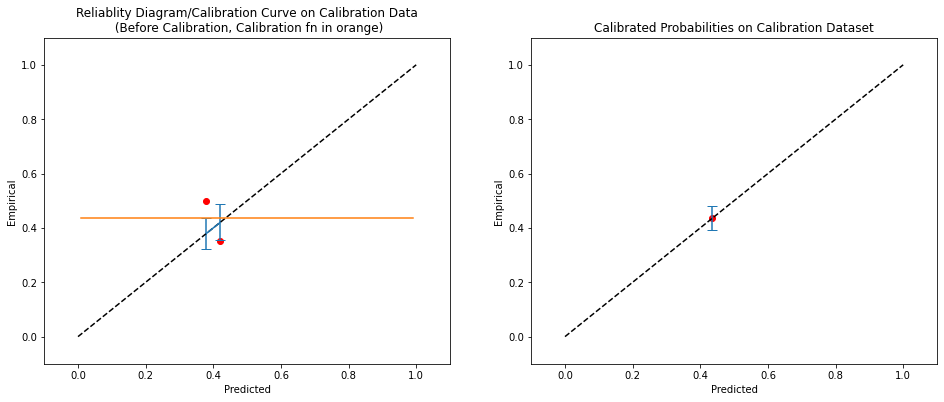

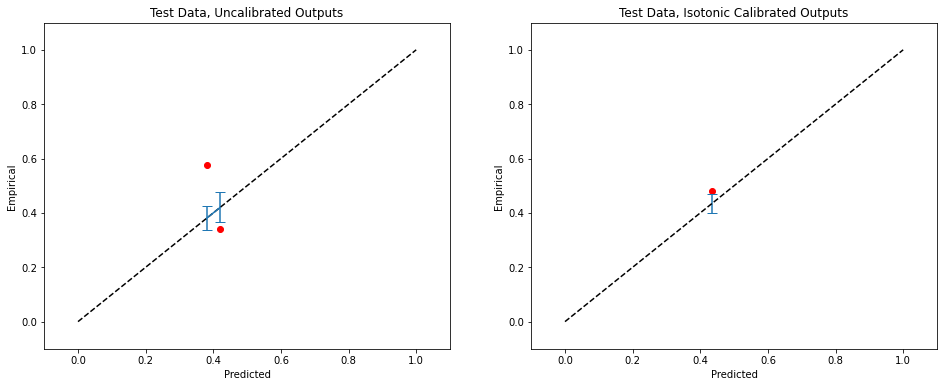

In [10]:
''' platt calibration function'''
pvec = np.linspace(.01, .99, 99)
isocalib = get_isotonic_calibrator(calibset_model_posterior, dataset.ycalib)


''' calibration set'''
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
mli.plot_reliability_diagram(dataset.ycalib, calibset_model_posterior.ravel())
plt.plot(pvec, isotonic_calibrate(isocalib, pvec.reshape(-1, 1)))
plt.title('Reliablity Diagram/Calibration Curve on Calibration Data\n (Before Calibration, Calibration fn in orange)')

plt.subplot(1,2,2)
yhat_calibset_iso = isotonic_calibrate(trained_calibrator=isocalib, yhat=calibset_model_posterior)
mli.plot_reliability_diagram(dataset.ycalib, yhat_calibset_iso)

plt.title('Calibrated Probabilities on Calibration Dataset')

# print(calibset_model_posterior.shape)
# print(testset_model_posterior.shape)
# print(calibset_model_posterior.)
''' test set'''
yhat_testset_iso = isotonic_calibrate(isocalib, testset_model_posterior)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
mli.plot_reliability_diagram(dataset.ytest, testset_model_posterior.ravel())
plt.title('Test Data, Uncalibrated Outputs')
plt.subplot(1,2,2)
mli.plot_reliability_diagram(dataset.ytest, yhat_testset_iso.ravel())
plt.title('Test Data, Isotonic Calibrated Outputs')
# plt.xlabel()

In [11]:
calset_uncalibrated_brier = brier_score_loss(dataset.ycalib, calibset_model_posterior)
calset_plattcalibrated_brier = brier_score_loss(dataset.ycalib, yhat_calibset_platt)
calset_isotonic_calibrated_brier= brier_score_loss(dataset.ycalib, yhat_calibset_iso)

testset_uncalibrated_brier = brier_score_loss(dataset.ytest, testset_model_posterior)
testset_plattcalibrated_brier = brier_score_loss(dataset.ytest, yhat_testset_platt) 
testset_isotoniccalibrated_brier = brier_score_loss(dataset.ytest, yhat_testset_iso) 

print(calset_uncalibrated_brier)
print(calset_plattcalibrated_brier)

print(testset_uncalibrated_brier)
print(testset_plattcalibrated_brier)
import pandas as pd

df = pd.DataFrame()
df_brier = pd.DataFrame([[calset_uncalibrated_brier, calset_plattcalibrated_brier, calset_isotonic_calibrated_brier], 
              [testset_uncalibrated_brier, testset_plattcalibrated_brier, testset_isotoniccalibrated_brier]], 
             columns=['UncalibratedBrier', 'PlattCalibratedBrier', 'IsotonicCalibratedBrier'], index=['Calib Set', 'TestSet'])
print(df_brier)
# pd.DataFram


0.2531682944445399
0.23295000894790702
0.2631951448038001
0.23439937006808706
           UncalibratedBrier  PlattCalibratedBrier  IsotonicCalibratedBrier
Calib Set           0.253168              0.232950                 0.245792
TestSet             0.263195              0.234399                 0.251613


In [12]:
''' Sampling function '''
def get_coreset(weights, Mc, smoothing = True, alpha=None):
    # input_data - n_samp x n_features    
    inds = np.arange(weights.shape[0])
    sampling_pmf = weights.ravel()
    if smoothing:
        smoothing_pmf = 1/weights.shape[0] 
        
        if alpha is not None:
            sampling_pmf = weights + alpha * smoothing_pmf
        
    sampling_pmf = sampling_pmf/sum(sampling_pmf)
    
    coreset_inds = np.random.choice(inds, size=Mc, replace=True, p=sampling_pmf)
#     coreset_inds = numpy.random.choice(input_data, size=Mc, replace=False, p=sampling_pmf) #This needs to be tried
    return coreset_inds

''' Compute coreset '''
def compute_ber_weights(ber_estimates, Mc, smoothing=True):
    pass

def get_ber_for_point(idx, xdata, gdist, mask, ylabel, neighborhood_size=None, kernel=None):

    if neighborhood_size is not None:
        neighborhoodsize=neighborhood_size
        samp = xdata[idx, :].reshape(1, -1)
        if sum(mask[idx])<neighborhood_size:
            kerneldata = xdata
            kernelgraph = gdist
            kernellabel = ylabel
        else:
            kerneldata = xdata[mask[idx],:]
            kernelgraph = gdist[mask[idx],:][:, mask[idx,:]]
            kernellabel = ylabel[mask[idx]]
        neighb = KNeighborsClassifier(n_neighbors=neighborhood_size)
        neighb = neighb.fit(kerneldata, kernellabel)
        dists, ids = neighb.kneighbors(samp)
        ids = ids.ravel()
        kerneldata = kerneldata[ids, :]
        kernelgraph = gdist[ids,:][:, ids]
        kernellabel = kernellabel[ids]
        
    else:
        kerneldata = xdata[mask[idx],:]
        kernelgraph = gdist[mask[idx],:][:, mask[idx,:]]
        kernellabel = ylabel[mask[idx]]
        neighborhoodsize=len(kerneldata)

#     if kernel=='gaussian':
#         kerneldata = 
        
    nn_indices = compute_neighbors(kerneldata, kerneldata)
    errors = np.sum(np.abs(kernellabel[nn_indices] - kernellabel))
#     localconnect = connect_matrix[mask[idx], :][:, mask[idx]]
#     dense_eudist = squareform(pdist(kerneldata))
#     eudist_csr = csr_matrix(kernelgraph)
#     mst = minimum_spanning_tree(eudist_csr)
#     mst = mst.toarray()
#     edgelist = np.transpose(np.nonzero(mst))

#     errors = np.sum(mst.astype(bool) * localconnect)
#     errors = np.sum(kernellabel[edgelist[:, 0]] != kernellabel[edgelist[:, 1]])

#     Dp = 1 - ((M + N) / (2 * M * N)) * errors
        
    N = np.sum(kernellabel==0)
    M = np.sum(kernellabel==1)
    if N==0 or M==0:
        kerneldp = 1.
        kernelBayesLB = 0.
    else:
        kerneldp = 1 - ((M + N) / (2 * M * N)) * errors
        if kerneldp<=0:
            kerneldp=0.
            kernelBayesLB = 0
        else:
            kernelBayesLB = .5 - .5 * np.sqrt(kerneldp)
#         if kernelBayesLB==math.nan:
#             kernelBayesLB=0.
#     if kerneldp<=0:
#         print(kerneldp, kernelBayesLB)
        
#     print(N, M, kerneldp, errors)
#     if kerneldp==np.nan or kerneldp<=0:
#         kerneldp=1
#         kernelBayesLB=0
    return (kernelBayesLB, kerneldp, neighborhoodsize)


def get_posterior_variance_weights(posterior_estimate, K):
#     for 
    pass


def generate_mst_coreset():
    pass


def train_coreset():
    pass


(array([1309.,    0.,  501.,  362.,  317.,  463.,  298.,  232.,  200.,
          67.]),
 array([0.        , 0.38729833, 0.77459667, 1.161895  , 1.54919334,
        1.93649167, 2.32379001, 2.71108834, 3.09838668, 3.48568501,
        3.87298335]),
 <BarContainer object of 10 artists>)

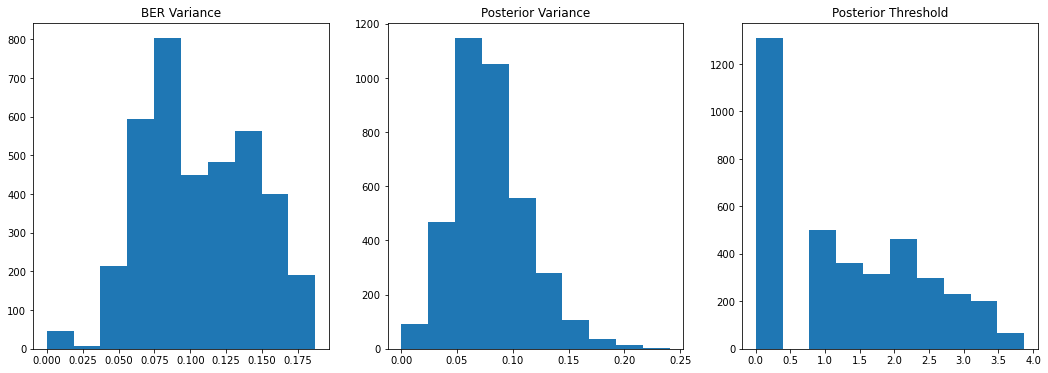

In [13]:
plt.figure(figsize=(18, 6), )
plt.subplot(1, 3, 1)
plt.title('BER Variance')
plt.hist(np.sqrt(trber_variance))

plt.subplot(1, 3, 2)
plt.title('Posterior Variance')
plt.hist(np.sqrt(trposterior_variance))

plt.subplot(1, 3, 3)
plt.title('Posterior Threshold')
plt.hist(np.sqrt(trposterior_thresh))



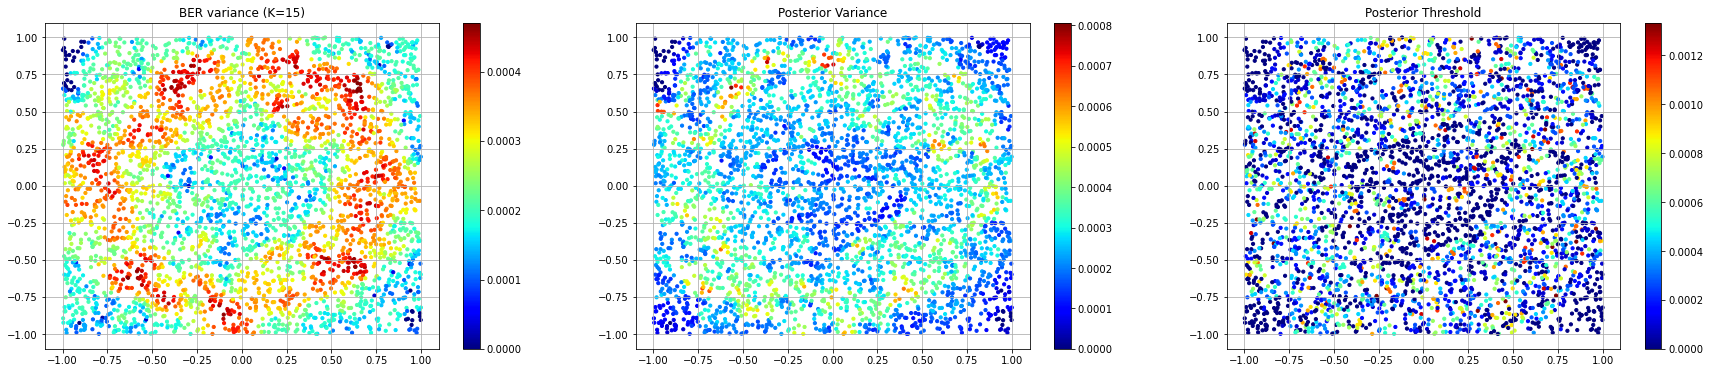

In [14]:

plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('BER variance (K=%d)' % knum)
tber_wts = np.sqrt(trber_variance)/sum(np.sqrt(trber_variance))
# tber_wts = trber_variance/sum(trber_variance)
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=tber_wts, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()

plt.subplot(1,3,2)
plt.title('Posterior Variance' )
tpos_wts = np.sqrt(trposterior_variance)/sum(np.sqrt(trposterior_variance))
# tpos_wts = trposterior_variance/sum(trposterior_variance)
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=tpos_wts, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.subplot(1,3,3)

plt.title('Posterior Threshold' )
plt.scatter(dataset.xtrain[:, 0], dataset.xtrain[:, 1], c=trposterior_thresh/sum(trposterior_thresh), s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.show()

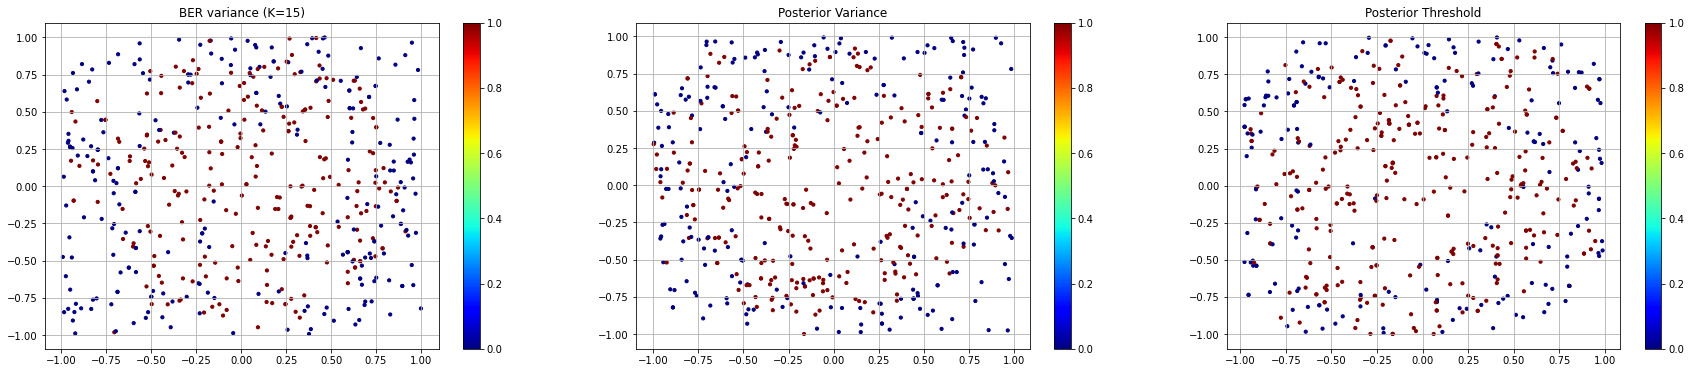

In [15]:
ber_cs_inds = get_coreset(weights=np.sqrt(trber_variance), Mc=500, smoothing = True, alpha=None)
posvar_cs_inds = get_coreset(weights=np.sqrt(trposterior_variance), Mc=500, smoothing = True, alpha=None)
posthresh_cs_inds = get_coreset(weights=trposterior_thresh, Mc=500, smoothing = True, alpha=None)

trainacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtrain, ydata=dataset.ytrain, score_fn=accuracy)
xbercs = dataset.xtrain[ber_cs_inds, :]
ybercs = dataset.ytrain[ber_cs_inds]

xposvarcs = dataset.xtrain[posvar_cs_inds, :]
yposvarcs = dataset.ytrain[posvar_cs_inds]

xposthreshcs = dataset.xtrain[posthresh_cs_inds, :]
yposthreshcs = dataset.ytrain[posthresh_cs_inds]

plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('BER variance (K=%d)' % knum)
plt.scatter(xbercs[:, 0], xbercs[:, 1], c=ybercs, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Posterior Variance' )
plt.scatter(xposvarcs[:, 0], xposvarcs[:, 1], c=yposvarcs, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Posterior Threshold' )
plt.scatter(xposthreshcs[:, 0], xposthreshcs[:, 1], c=yposthreshcs, s=10, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.show()

In [16]:
clf_type = 'svm'
svmclf = train_classifier(xbercs, ybercs, classifier=clf_type)
trainacc = evaluate_classifier(clf=svmclf, xdata=xbercs, ydata=ybercs, score_fn=accuracy)
testacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtest, ydata=dataset.ytest, score_fn=accuracy)

testset_model_posterior = svmclf.predict_proba(dataset.xtest)[:, 1].reshape(-1, 1)
# 

print('Trained SVM with test accuracy: %.2f' % testacc)
print('test set acccuracy: %.2f ' % testacc)
print(brier_score_loss(dataset.ytest, testset_model_posterior))

# print('It is clear that the SVM is not calibrated')

svmclf = train_classifier(xposvarcs, yposthreshcs, classifier=clf_type)
trainacc = evaluate_classifier(clf=svmclf, xdata=xbercs, ydata=ybercs, score_fn=accuracy)
testacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtest, ydata=dataset.ytest, score_fn=accuracy)
testset_model_posterior = svmclf.predict_proba(dataset.xtest)[:, 1].reshape(-1, 1)
# print(brier_score_loss(dataset.ytest, testset_model_posterior))
print('\nTrained SVM with test accuracy: %.2f' % testacc)
print('test set acccuracy: %.2f ' % testacc)
print(brier_score_loss(dataset.ytest, testset_model_posterior))

# print('Calibration set acccuracy: %.2f ' % calibacc)
# print('It is clear that the SVM is not calibrated')


svmclf = train_classifier(xposthreshcs, yposthreshcs, classifier=clf_type)
trainacc = evaluate_classifier(clf=svmclf, xdata=xbercs, ydata=ybercs, score_fn=accuracy)
testacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtest, ydata=dataset.ytest, score_fn=accuracy)
testset_model_posterior = svmclf.predict_proba(dataset.xtest)[:, 1].reshape(-1, 1)
# print(brier_score_loss(dataset.ytest, testset_model_posterior))
print('\nTrained SVM with test accuracy: %.2f' % testacc)
print('test set acccuracy: %.2f ' % testacc)
print(brier_score_loss(dataset.ytest, testset_model_posterior))

# print('Calibration set acccuracy: %.2f ' % calibacc)
# print('It is clear that the SVM is not calibrated')

Trained SVM with test accuracy: 0.71
test set acccuracy: 0.71 
0.19418966306273566

Trained SVM with test accuracy: 0.40
test set acccuracy: 0.40 
0.2604727637051282

Trained SVM with test accuracy: 0.71
test set acccuracy: 0.71 
0.20595146464724579


Trained SVM with test accuracy: 0.68
Calibration set acccuracy: 0.71 
It is clear that the SVM is not calibrated


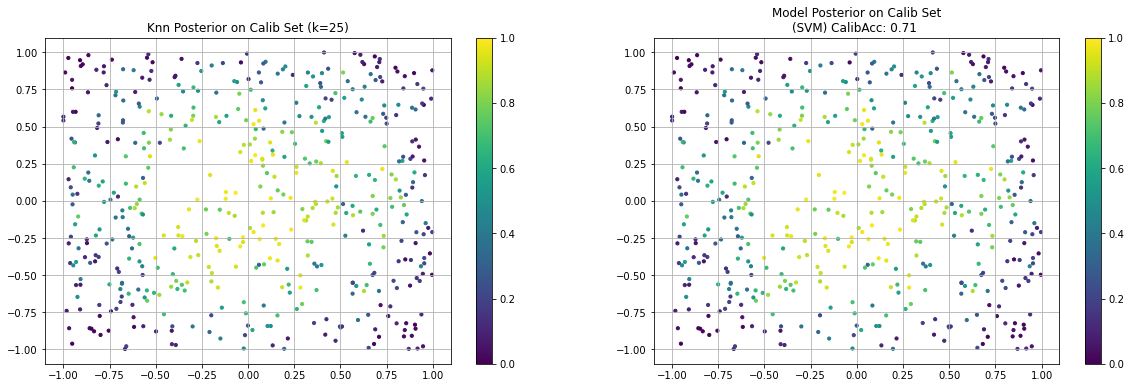

/home/prad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/prad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'Num Points in Bin')

<Figure size 432x288 with 0 Axes>

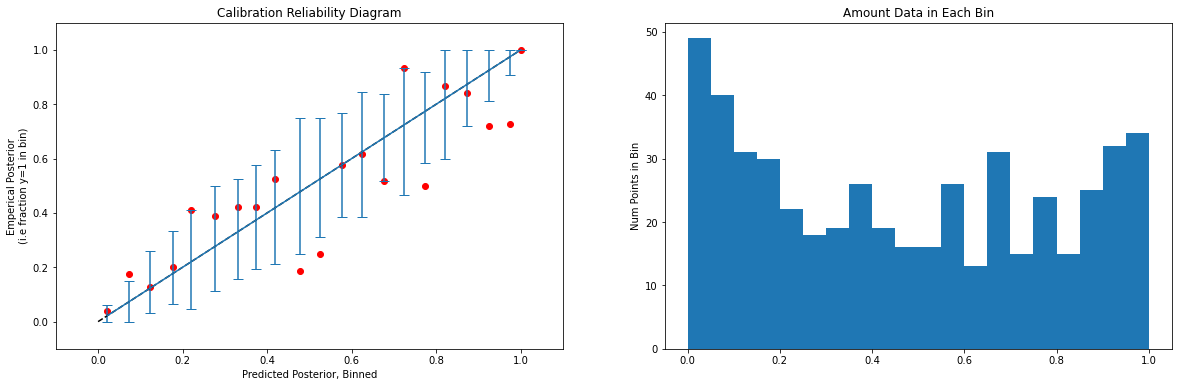

In [17]:
''' Train model, and evaluate if it is calibrated '''

knum = 25
kcalib = int(knum * dataset.calib_frac/dataset.train_frac)
ktest = int(knum * dataset.calib_frac/dataset.train_frac)
#train model (SVM)
svmclf = train_classifier(dataset.xtrain, dataset.ytrain, classifier='forest')

#evaluate accuracy
trainacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtrain, ydata=dataset.ytrain, score_fn=accuracy)
calibacc = evaluate_classifier(clf=svmclf, xdata=dataset.xcalib, ydata=dataset.ycalib, score_fn=accuracy)
testacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtest, ydata=dataset.ytest, score_fn=accuracy)
print('Trained SVM with test accuracy: %.2f' % testacc)
print('Calibration set acccuracy: %.2f ' % calibacc)
print('It is clear that the SVM is not calibrated')

#evaluate model posterior
trscore = svmclf.predict_proba(dataset.xtrain)
calibscore = svmclf.predict_proba(dataset.xcalib)
calibset_model_posterior = calibscore[:, 1].reshape(-1, 1)
testset_model_posterior = svmclf.predict_proba(dataset.xtest)[:, 1].reshape(-1, 1)

# Knn posterior 
trposterior, trber, trposterior_variance, trber_variance, trposterior_thresh = simple_knn_posterior_estimate(data=dataset.xtrain, labels=dataset.ytrain, k=knum)
calibposterior, calibber, calposterior_variance, calber_variance, calposterior_thresh = simple_knn_posterior_estimate(data=dataset.xcalib, labels=dataset.ycalib, k=knum)
testsetposterior, testsetber, teposterior_variance, teber_variance, teposterior_thresh = simple_knn_posterior_estimate(data=dataset.xtest, labels=dataset.ytest, k=ktest)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Knn Posterior on Calib Set (k=%d)' % knum)
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Model Posterior on Calib Set\n(SVM) CalibAcc: %.2f ' % (calibacc))
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.show()

plt.figure()
# rd = mli.plot_reliability_diagram(dataset.ycalib, calibscore[:,1])
plt.figure(figsize=(20,6))
mli.plot_reliability_diagram(dataset.ycalib, calibset_model_posterior.ravel(), show_histogram=True);
plt.subplot(1,2,1)

plt.title('Calibration Reliability Diagram')
plt.ylabel('Emperical Posterior\n(i.e fraction y=1 in bin)')
plt.xlabel('Predicted Posterior, Binned')
plt.subplot(1,2,2)

plt.title('Amount Data in Each Bin')
plt.ylabel('Num Points in Bin')

# 

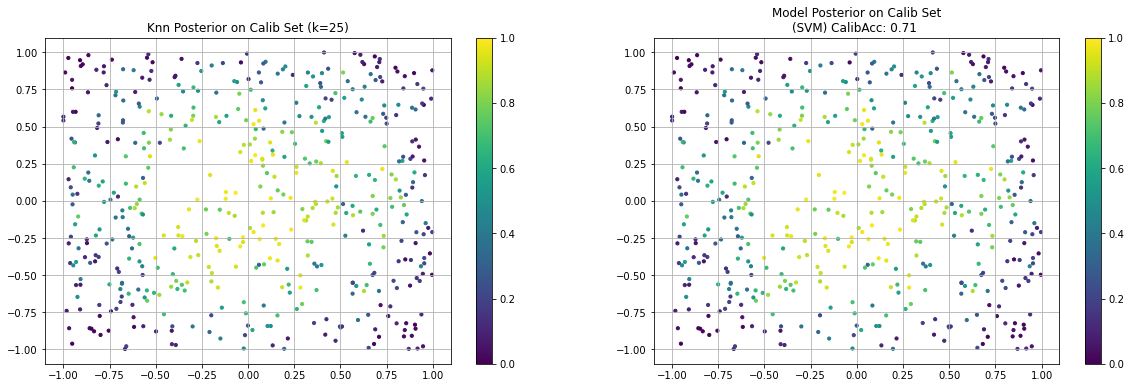

/home/prad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/prad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'Num Points in Bin')

<Figure size 432x288 with 0 Axes>

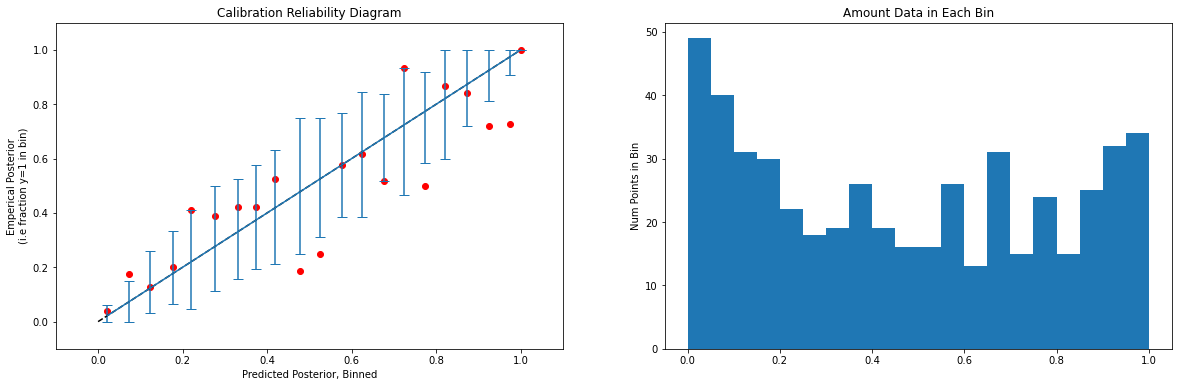

In [18]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Knn Posterior on Calib Set (k=%d)' % knum)
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Model Posterior on Calib Set\n(SVM) CalibAcc: %.2f ' % (calibacc))
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.show()

plt.figure()
# rd = mli.plot_reliability_diagram(dataset.ycalib, calibscore[:,1])
plt.figure(figsize=(20,6))
mli.plot_reliability_diagram(dataset.ycalib, calibset_model_posterior.ravel(), show_histogram=True);
plt.subplot(1,2,1)

plt.title('Calibration Reliability Diagram')
plt.ylabel('Emperical Posterior\n(i.e fraction y=1 in bin)')
plt.xlabel('Predicted Posterior, Binned')
plt.subplot(1,2,2)

plt.title('Amount Data in Each Bin')
plt.ylabel('Num Points in Bin')

In [19]:
"-----------------------------------------------------------------------------------------------------------------------------------------------------------"

'-----------------------------------------------------------------------------------------------------------------------------------------------------------'

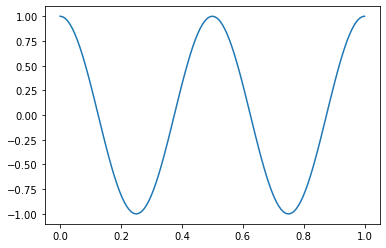

/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


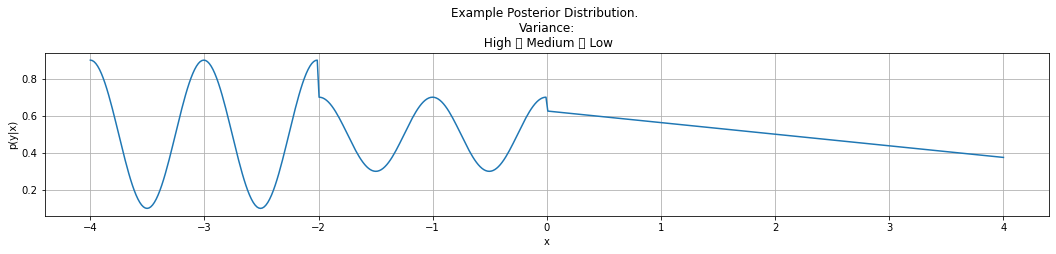

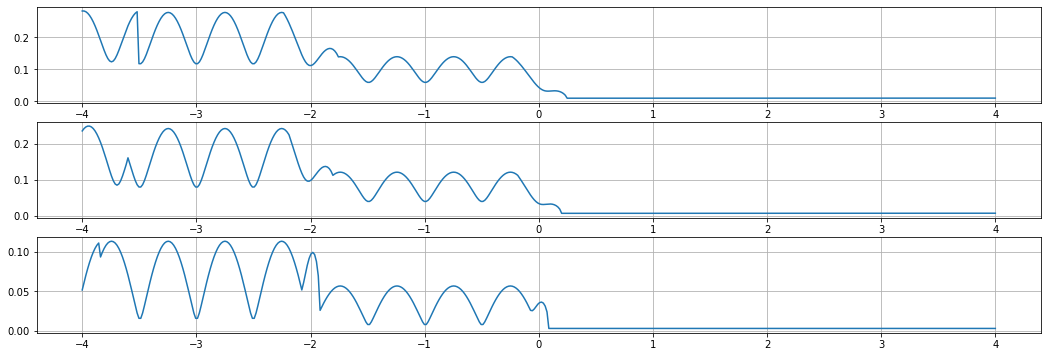

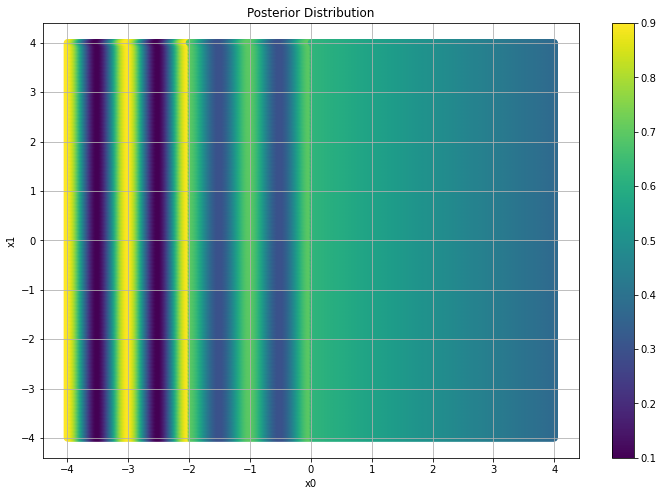

Computed k=5
Computed k=10
Computed k=15
Computed k=25
Computed k=50
Computed k=100
Computed k=500


/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


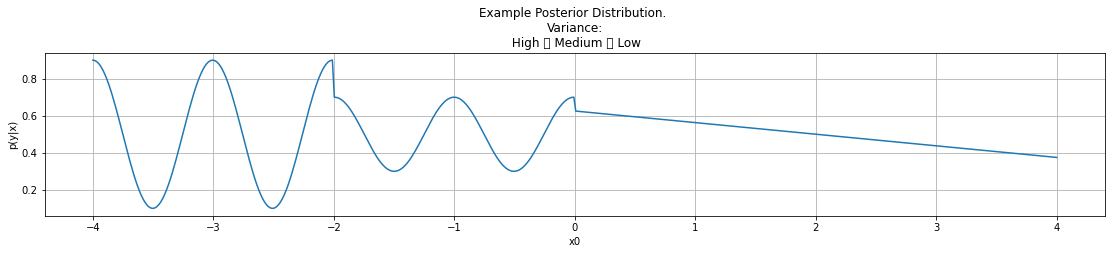

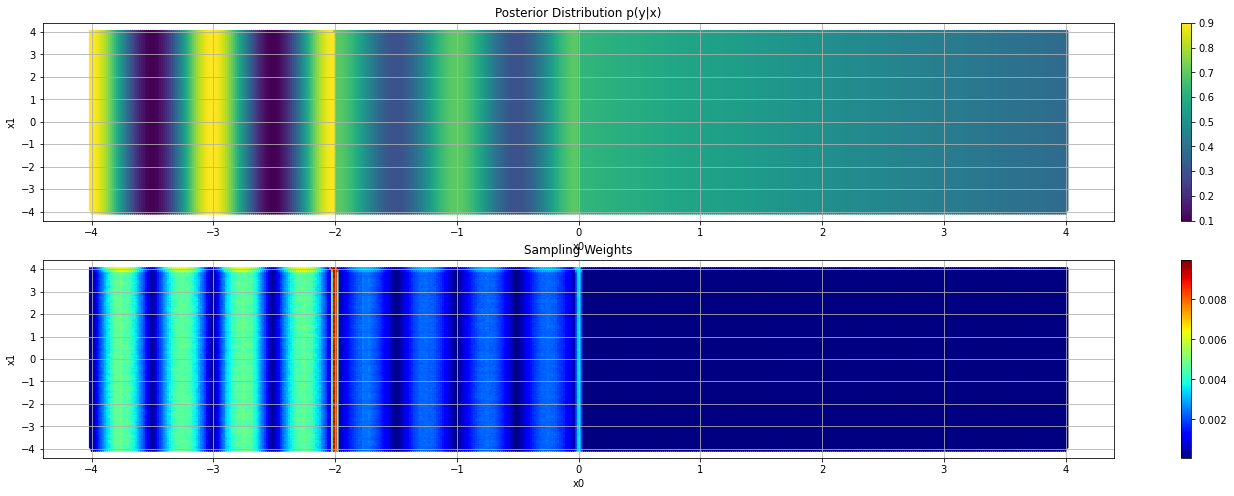

In [21]:
xsin = np.linspace(0, 1, 125)  
cosdata = np.cos(2 * np.pi * 2 * xsin)
plt.show()
plt.plot(xsin, cosdata)


plt.figure(figsize=(18,3))
xrange = np.linspace(-4, 4, 500)
yrange = np.zeros([500])
yrange[:125] = .4 * cosdata
yrange[125:250] = .2 * cosdata
yrange[250:500] = -.25 * np.linspace(-2, -1, 250) - .375
yrange = yrange + .5

# averagewin = 3
# for ii in range(len(yrange)):
#     if ii<averagewin or ii>len(yrange)-averagewin:
#         pass
#     else:
#         yrange[ii] = np.mean(yrange[ii-averagewin:ii+averagewin])
    
plt.plot(xrange, yrange)
plt.ylabel('p(y|x)')
plt.xlabel('x')
plt.title('Example Posterior Distribution. \nVariance:\n High \t Medium \t Low')
plt.grid()


bw = .5
smp_bw = int(bw * len(xrange)/8)
def calc_1d_wts(posterior, kvalue):
    estimated_var = np.zeros([len(posterior)])
    for ii in range(len(yrange)):
        if ii<kvalue:
            estimated_var[ii] = np.var(yrange[ii:ii+kvalue])
        elif ii>len(yrange)-kvalue:
            estimated_var[ii] = np.var(yrange[ii-kvalue:ii])
        else:
            estimated_var[ii] = np.var(yrange[ii-int(kvalue/2):ii+int(kvalue/2)])
    return estimated_var
        
plt.figure(figsize=(18,6))
plt.subplot(3, 1, 1)
plt.plot(xrange, np.sqrt(calc_1d_wts(posterior=yrange, kvalue=smp_bw)))
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(xrange, np.sqrt(calc_1d_wts(posterior=yrange, kvalue=25)))
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(xrange, np.sqrt(calc_1d_wts(posterior=yrange, kvalue=10)))
plt.grid()

ygrid = np.zeros([len(xrange), len(xrange)])
ygrid[:, :] = yrange
xx0, xx1 = np.meshgrid(xrange, xrange)
xx0 = xx0.ravel()
xx1 = xx1.ravel()
yposterior = ygrid.ravel()
plt.figure(figsize=(12,8))
plt.scatter(xx0, xx1, c=yposterior)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Posterior Distribution')
plt.grid()
plt.colorbar()
plt.show()

n_points = len(xrange)

kvalue = 15
xdata = np.vstack([xx0, xx1]).T

def get_sampling_distribution(xfeatures, posterior, kvalue):
    nbrs = NearestNeighbors(n_neighbors = kvalue + 1).fit(xfeatures)
    distances, inds = nbrs.kneighbors(xfeatures)
    labels = yposterior>=.5

    weights = np.zeros_like(yposterior)
    neighb_bw = np.zeros_like(yposterior)
    n_points = len(posterior)
    for ii in range(n_points):
#         neighborlabels = labels[]
        neighb_post = yposterior[inds[ii, 1:]]
        weights[ii] = np.var(neighb_post)
        neighb_bw[ii] = np.max(distances[ii])
    print('Computed k=%d' % kvalue)
    
    return weights, neighb_bw
        
k5_weights, k5_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 5)
k10_weights, k10_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 10)
k15_weights, k15_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 15)
k25_weights, k25_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 25)
k50_weights, k50_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 50)
k100_weights, k100_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 100)
k500_weights, k500_bws = get_sampling_distribution(xfeatures = xdata, posterior = yposterior, kvalue = 500)

k5_weights = k5_weights/sum(k5_weights)
k10_weights = k10_weights/sum(k10_weights)
k15_weights = k15_weights/sum(k15_weights)
k25_weights = k25_weights/sum(k25_weights)
k50_weights = k50_weights/sum(k50_weights)
k100_weights = k100_weights/sum(k100_weights)
k500_weights = k500_weights/sum(k500_weights)

plt.figure(figsize=(19,3))
plt.plot(xrange, yrange)
plt.ylabel('p(y|x)')
plt.xlabel('x0')
plt.title('Example Posterior Distribution. \nVariance:\n High \t Medium \t Low')
plt.grid()

plt.figure(figsize=(24,8))
plt.subplot(2, 1, 1)
plt.scatter(xx0, xx1, marker='1', c=yposterior)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Posterior Distribution p(y|x)')
plt.grid()
plt.colorbar()

plt.subplot(2, 1, 2)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k15_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights')
plt.grid()
plt.colorbar()

plt.show()


# def oracle():
#     pass

/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


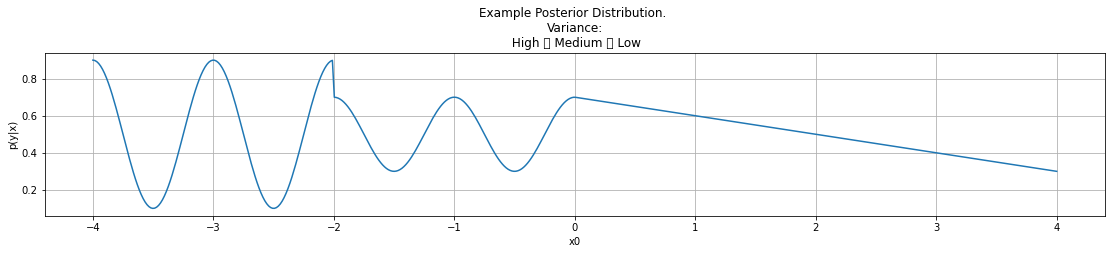

In [ ]:
''' SVM classifier with 100% labeled data '''

# def train_test_classifier(train_dataset, test_dataset, validation_dataset, classifier='svm'):
#     pass

N = []
xdata = 8 * (np.random.rand(N, 2) - .5)
ypost = np.array([oracle(xdata[_ii, :]) for _ii in range(xdata.shape[0])])
plt.scatter(xdata[:, 0], xdata[:, 1], marker='.', c=ypost)

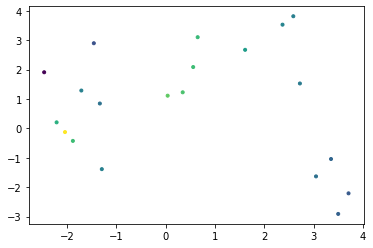

In [58]:
''' Convex Hull Idea '''


In [ ]:
'''  '''
xdata = 


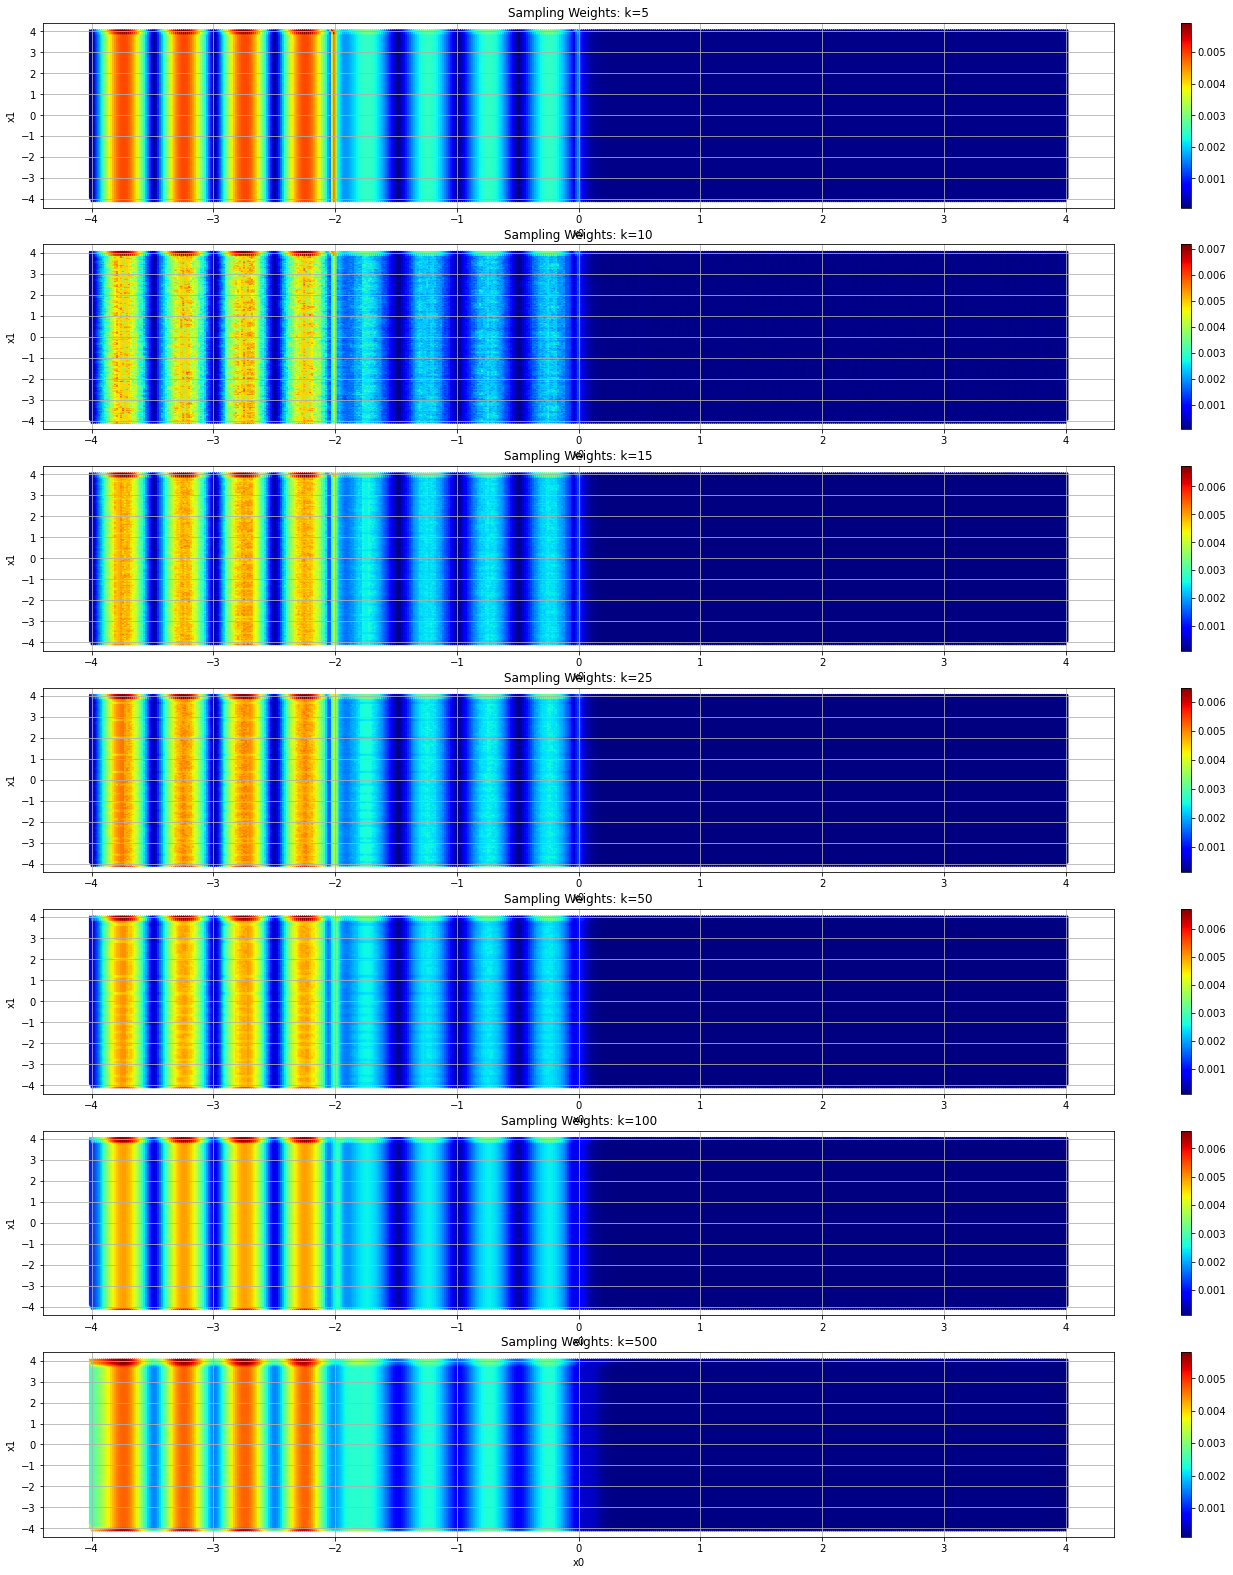

/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


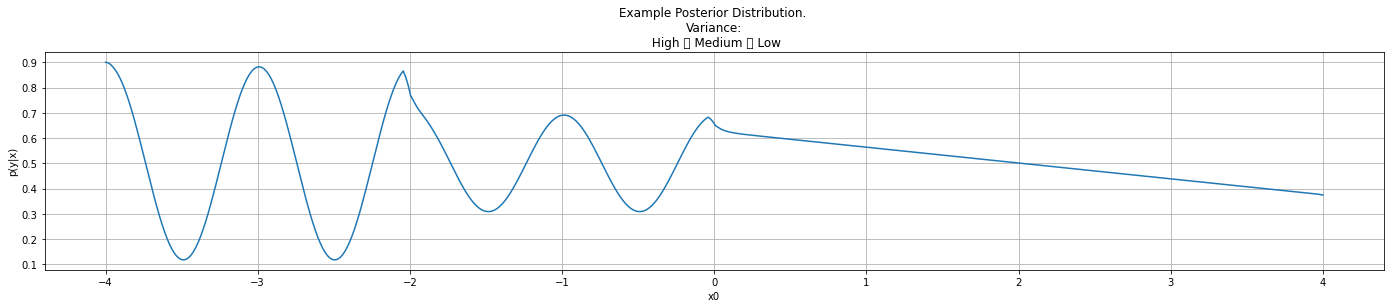

In [28]:

plt.figure(figsize=(24, 36))
plt.subplot(9, 1, 1)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k5_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=5')
plt.grid()
plt.colorbar()

plt.subplot(9, 1, 2)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k10_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=10')
plt.grid()
plt.colorbar()

plt.subplot(9, 1, 3)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k15_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=15')
plt.grid()
plt.colorbar()

plt.subplot(9, 1, 4)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k25_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=25')
plt.grid()
plt.colorbar()

plt.subplot(9, 1, 5)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k50_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=50')
plt.grid()
plt.colorbar()

plt.subplot(9, 1, 6)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k100_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=100')
plt.grid()
plt.colorbar()

plt.subplot(9, 1, 7)
plt.scatter(xx0, xx1, marker='1', c=np.sqrt(k500_weights), cmap=plt.cm.jet)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Sampling Weights: k=500')
plt.grid()
plt.colorbar()

plt.figure(figsize=(24,4))
# plt.subplot(9, 1, 8)
plt.plot(xrange, yrange)
plt.ylabel('p(y|x)')
plt.xlabel('x0')
plt.title('Example Posterior Distribution. \nVariance:\n High \t Medium \t Low')
plt.grid()
plt.show()



Split dataset. n_train 187499, n_calib 25001, n_test 37500.


Text(0, 0.5, 'x1')

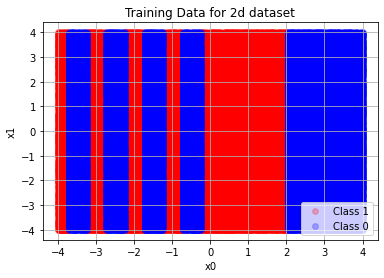

In [31]:
ydata = yposterior>=.5
dataset = MyDataset(x_data = xdata, y_data = ydata)


# xlin, ylin = gen_linear_dataset(N=10000, sigma=.5)
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score


dataset.gen_splits(train_frac=trainfrac, calib_frac=calibfrac, test_frac=testfrac)
plot_2d_dataset(dataset.xtrain, dataset.ytrain, title = 'Training Data for 2d dataset')
''' Train model, and evaluate if it is calibrated '''
plt.xlabel('x0')
plt.ylabel('x1')


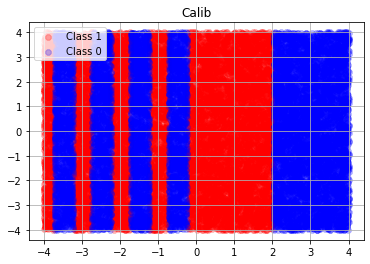

In [34]:
plot_2d_dataset(dataset.xcalib, dataset.ycalib, title='Calib')

In [23]:
print('Started Training')
svmclf = train_classifier(dataset.xtrain, dataset.ytrain, classifier='svm')
print('Trained model')

Started Training
Trained model


/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [25]:
#evaluate accuracy
trainacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtrain, ydata=dataset.ytrain, score_fn=accuracy)
calibacc = evaluate_classifier(clf=svmclf, xdata=dataset.xcalib, ydata=dataset.ycalib, score_fn=accuracy)
testacc = evaluate_classifier(clf=svmclf, xdata=dataset.xtest, ydata=dataset.ytest, score_fn=accuracy)
print(testacc)
print('Trained SVM with test accuracy: %.2f' % testacc)
print('Calibration set acccuracy: %.2f ' % calibacc)
print('It is clear that the SVM is not calibrated')


0.6592
Trained SVM with test accuracy: 0.66
Calibration set acccuracy: 0.66 
It is clear that the SVM is not calibrated


In [ ]:
#evaluate model posterior
trscore = svmclf.predict_proba(dataset.xtrain)
calibscore = svmclf.predict_proba(dataset.xcalib)
calibset_model_posterior = calibscore[:, 1].reshape(-1, 1)
testset_model_posterior = svmclf.predict_proba(dataset.xtest)[:, 1].reshape(-1, 1)

# Knn posterior 
trposterior, trber, trposterior_variance, trber_variance, trposterior_thresh = simple_knn_posterior_estimate(data=dataset.xtrain, labels=dataset.ytrain, k=knum)
calibposterior, calibber, calposterior_variance, calber_variance, calposterior_thresh = simple_knn_posterior_estimate(data=dataset.xcalib, labels=dataset.ycalib, k=knum)
testsetposterior, testsetber, teposterior_variance, teber_variance, teposterior_thresh = simple_knn_posterior_estimate(data=dataset.xtest, labels=dataset.ytest, k=ktest)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Knn Posterior on Calib Set (k=%d)' % knum)
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Model Posterior on Calib Set\n(SVM) CalibAcc: %.2f ' % (calibacc))
plt.scatter(dataset.xcalib[:, 0], dataset.xcalib[:, 1], c=calibset_model_posterior, s=10, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.show()

plt.figure()
# rd = mli.plot_reliability_diagram(dataset.ycalib, calibscore[:,1])
plt.figure(figsize=(20,6))
mli.plot_reliability_diagram(dataset.ycalib, calibset_model_posterior.ravel(), show_histogram=True);
plt.subplot(1,2,1)

plt.title('Calibration Reliability Diagram')
plt.ylabel('Emperical Posterior\n(i.e fraction y=1 in bin)')
plt.xlabel('Predicted Posterior, Binned')
plt.subplot(1,2,2)

plt.title('Amount Data in Each Bin')
plt.ylabel('Num Points in Bin')

# 

Split dataset. n_train 187499, n_calib 25001, n_test 37500.


In [ ]:
bandwidths = [k5_bws, k10_bws, k15_bws, k25_bws, k50_bws, k100_bws, k500_bws]
kvals = [5, 10, 15, 25, 50, 100, 500]
bandwidths = [np.mean(_bw) for _bw in bandwidths]
plt.plot(kvals, bandwidths, '-o')
plt.title('Value of K vs Avg. Distance to Neighb. Points')
plt.ylabel('Average Neighborhood Distance')
plt.xlabel('K value')
plt.grid()

plt.figure(figsize=(8, 36))
plt.subplot(9, 1, 1)
plt.hist(k5_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=5')
plt.grid()

plt.subplot(9, 1, 2)
plt.hist(k10_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=10')
plt.grid()

plt.subplot(9, 1, 3)
plt.hist(k15_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=15')
plt.grid()

plt.subplot(9, 1, 4)
plt.hist(k25_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=25')
plt.grid()

plt.subplot(9, 1, 5)
plt.hist(k50_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=50')
plt.grid()

plt.subplot(9, 1, 6)
plt.hist(k100_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=100')
plt.grid()

plt.subplot(9, 1, 7)
plt.hist(k500_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=500')
plt.grid()

plt.subplot(9, 1, 8)
plt.hist(k1000_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=1000')
plt.grid()

plt.subplot(9, 1, 9)
plt.hist(k5_weights.ravel(), bins=100, log=True)
plt.xlabel('Weight')
plt.title('Sampling Weights Histogram for k=5')
plt.grid()
plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


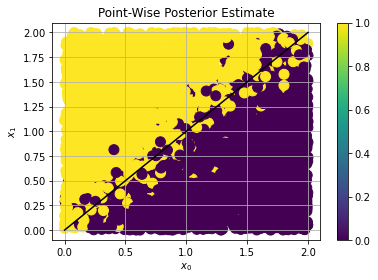

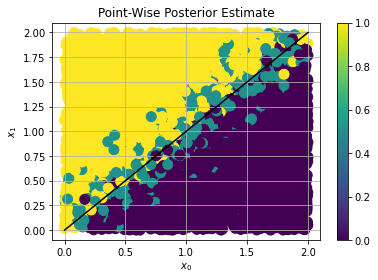

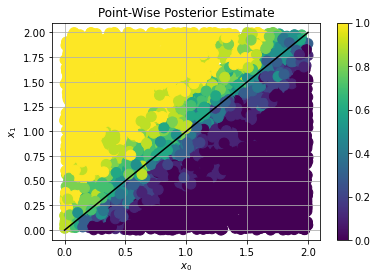

In [22]:
''' Generate and plot the defeat dataset'''

def generate_defeat_dataset(N=5000):
    x_data = np.zeros([N,2])
    y_gt = np.zeros([N,1])
    
    for ii in range(N):
        x0 = np.random.rand()
        x1 = np.random.rand()
        
        if x0<.5:
            pass
        
    return 0
            

# for ii in range
posterior = simple_knn_posterior_estimate(xlin, ylin, k = 1)
plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=posterior, s=100, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.plot([0, 2], [0, 2], 'k')
plt.title('Point-Wise Posterior Estimate')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

posterior = simple_knn_posterior_estimate(xlin, ylin, k = 2)
plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=posterior, s=100, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.plot([0, 2], [0, 2], 'k')
plt.title('Point-Wise Posterior Estimate')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

posterior = simple_knn_posterior_estimate(xlin, ylin, k = 10)
plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=posterior, s=100, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.plot([0, 2], [0, 2], 'k')
plt.title('Point-Wise Posterior Estimate')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

Text(0, 0.5, '$x_1$')

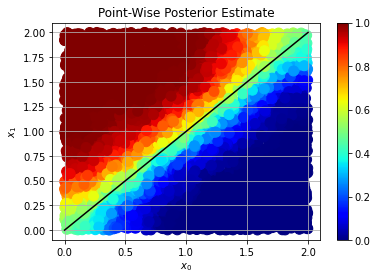

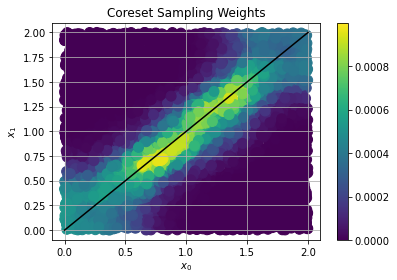

In [9]:
posterior = simple_knn_posterior_estimate(xlin, ylin, k = 200)
weights = importance_sample(xlin, posterior, posterior_k = 200)
plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=posterior, s=100, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.plot([0, 2], [0, 2], 'k')
plt.title('Point-Wise Posterior Estimate')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=weights, s=100, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.plot([0, 2], [0, 2], 'k')
plt.title('Coreset Sampling Weights')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

In [7]:
nbrs = NearestNeighbors(n_neighbors= 21).fit(xlin)
distances, indices = nbrs.kneighbors(xlin)
neighbinds = indices[1, 1:]
ylin[neighbinds]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
clf = train_classifier()


In [ ]:
''' Calibration functions'''

def plat_calibrate(model_scores):
    pass

def isotonic_calibration():
    pass

In [ ]:
''' Generation coreset functions'''
def extract_classification_coreset():
    pass


def extract_calibration_coreset():
    pass

In [11]:
simple_knn_posterior_estimate(data = xlin, labels = ylin, k=100)

array([[0.17],
       [1.  ],
       [0.27],
       ...,
       [0.  ],
       [0.91],
       [0.19]])

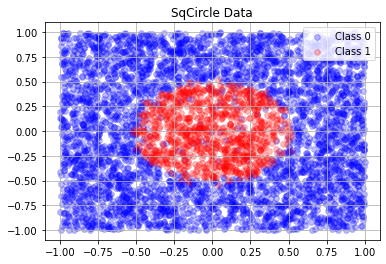

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# from slkearn
x0square, x1circle, labels = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.1)

x0square, x1circle, ysqcirc = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.025)
xdata = np.vstack([x0square, x1circle])

plot_2d_dataset(xdata, labels, 'SqCircle Data')

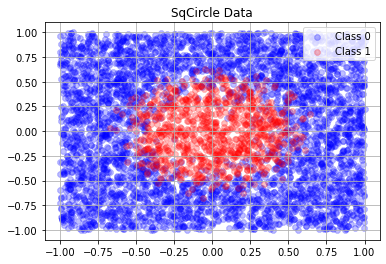

In [15]:
x0square, x1circle, labels = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.1)
xdata = np.vstack([x0square, x1circle])
plot_2d_dataset(xdata, labels, 'SqCircle Data')

x0square, x1circle, ysqcirc = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.025)
xdata = np.vstack([x0square, x1circle])



Text(0, 0.5, '$x_1$')

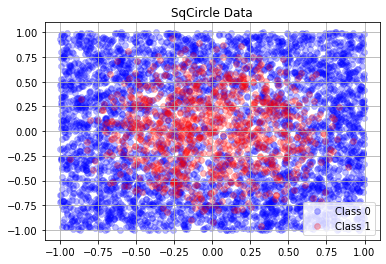

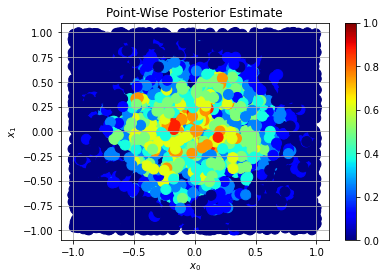

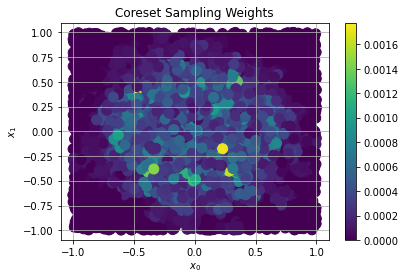

In [16]:
x0square, x1circle, ysqcirc = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.33)
xdata = np.vstack([x0square, x1circle])

posterior = simple_knn_posterior_estimate(xdata, labels, k = 8)
weights = importance_sample(xdata, posterior, posterior_k = 10)
plot_2d_dataset(xdata, labels, 'SqCircle Data')


plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=posterior, s=100, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise Posterior Estimate')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=weights, s=100, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.title('Coreset Sampling Weights')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

In [ ]:
train_pct = .75
calib_pct = .1
test_pct = 1 - train_pct - calib_pct 
rs = 42
xtraincal1, xte1, ytraincal1, yte1 = train_test_split(xdata, labels, test_size=test_pct, random_state = rs)
xtr1, xcal1, ytr1, ycal1 = train_test_split(xtraincal1, ytraincal1, test_size=calib_pct/(1 - test_pct), random_state = rs)
xtr1.shape, xcal1.shape, xte1.shape

Text(0, 0.5, '$x_1$')

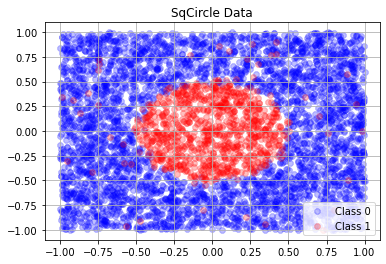

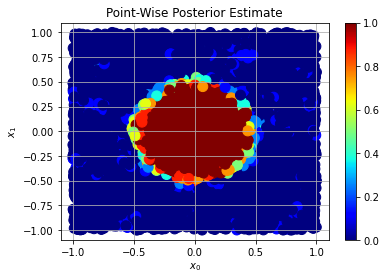

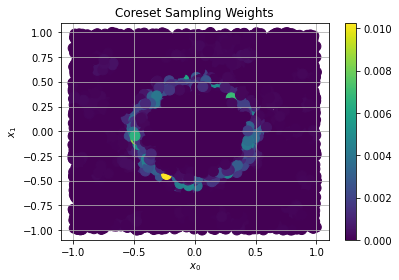

In [106]:
plot_2d_dataset(xdata, labels, 'SqCircle Data')
posterior = simple_knn_posterior_estimate(xdata, labels, k = 8)
weights = importance_sample(xdata, posterior, posterior_k = 10)

plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=posterior, s=100, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise Posterior Estimate')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=weights, s=100, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()
plt.title('Coreset Sampling Weights')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')